# Exploratory Data Analysis

* [1. Integer-type features](#1)
* [2. Float-type features](#2)
* [3. String-type features](#3)   
* [4. Datetime-type features](#4)    
* [5. Summary](#5)

The vast majority of the features in our anonymized dataset are numerical columns (1837 integers and 10 floats) with a tiny admixture of categorical ones (17 strings and 16 datetime types). In principle, numerical features can easily be fed into machine learning models with no need for understaning their meanings. The only challenge we're facing is a complicated structure of missing values encoded by NaNs or various integers (-99999, -1, 99, 999, 9999, 9999999999), which we will explore it in this section. We will also investigate categorical features and propose an optimal way to replace them with numerical ones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#common for all
y = pd.read_csv("./data/work_target.csv",index_col='ID',low_memory=False)
y.shape

(145231, 1)

### 1. Integer-type features<a id='1'></a>

In [2]:
dfi = pd.read_csv("./data/work_integers.csv",index_col='ID',low_memory=False).convert_dtypes()
dpi = pd.read_csv("./data/pred_integers.csv",index_col='ID',low_memory=False).convert_dtypes()

dfi.shape, dpi.shape

((145231, 1837), (145232, 1837))

Let's start with missing values encoded with negative integers, -1 and -99999. They populate high number of rows in the columns depicted with the dark- and light-blue colors on the plot in Sec. 4.1 of the [previous notebook](./data_wrangling.ipynb#4.1). Let's begin with the columns containing -1. Let's remove -1 from the dataset and check what are the next smallest numbers:

In [3]:
dfi_min = dfi.min()

cols_a = dfi_min[dfi_min == -1].index
print(len(cols_a),'columns')

dfi_a = dfi[cols_a][dfi[cols_a] > -1]
set(dfi_a.min())

104 columns


{0.0, 1.0, 3.0, 15.0, 1995.0}

The smallest is the zero. OK. Let's do the same for the columns with -99999. Let's remove -99999 from the spectrum and check for the next smallest numbers in the new subsample:

In [4]:
cols_b = dfi_min[dfi_min == -99999].index
print(len(cols_b),'columns')

dfi_b = dfi[cols_b][dfi[cols_b] > -99999]
set(dfi_b.min())

156 columns


{0.0, 1.0, 6.0, 9.0, 18.0, 20.0, 56.0, 374.0, 456.0, 5000.0}

Cool. The smallest is the zero again. The same situation as for -1. So we will replace -99999 with -1. Should we keep a track of this replacement? Is there any change in the behavior of the target variable for rows containing these two minimal values, compared to the overall sample?:

In [5]:
print('\t\t   target average')
print('rows with     -1:\t', y[(dfi[cols_a] ==     -1).sum(axis=1) > 0].mean().round(4).values[0])
print('rows with -99999:\t', y[(dfi[cols_b] == -99999).sum(axis=1) > 0].mean().round(4).values[0])
print('the whole sample:\t', y.mean().round(4).values[0])

		   target average
rows with     -1:	 0.2326
rows with -99999:	 0.2325
the whole sample:	 0.2325


Nope, no change. So indeed, the two numbers had the same meaning. Done.

Can we get a feeling of what kind of distributions are we dealing with? Obviously, it's pointless to plot hundreds of variables, so let's quickly inspect their main characteristics  as given by the standard box plots (the median, 1st and 3rd quantiles, Tukey's wiskers, etc). Let's order the columns by their max values and set a logarithmic scale on the y axis:

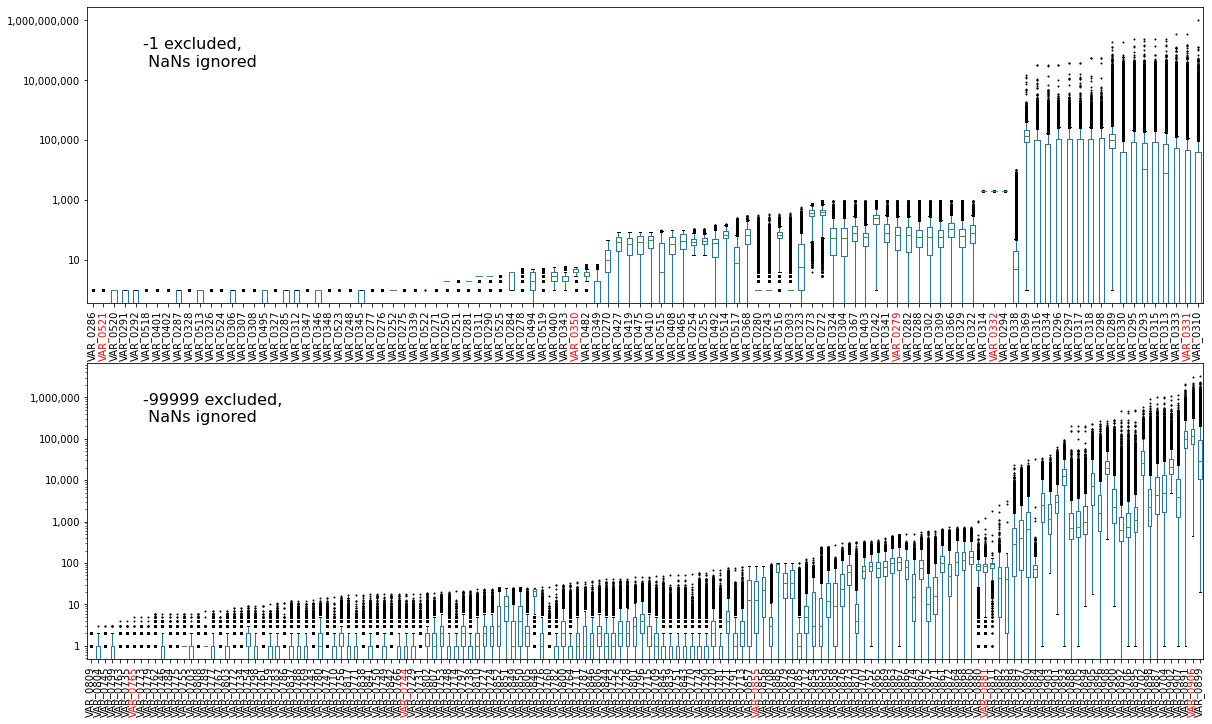

In [6]:
fig, ax = plt.subplots(2,1,figsize=(20,12))

cols_a_sorted = dfi_a.max().sort_values().index
cols_b_sorted = dfi_b.max().sort_values().index

dfi_a[cols_a_sorted].plot.box(ax=ax[0],flierprops=dict(markersize=1))
dfi_b[cols_b_sorted].plot.box(ax=ax[1],flierprops=dict(markersize=1))

cols_to_plot = [['VAR_0521','VAR_0350','VAR_0279','VAR_0332','VAR_0331'],
                ['VAR_0765','VAR_0744','VAR_0855','VAR_0881','VAR_0906']]

for i in range(len(ax)):
                  
    ax[i].set_yscale('log')
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 90)
    ax[i].text(0.05, 0.8, ('-1' if i<1 else '-99999') + ' excluded,\n NaNs ignored', transform=ax[i].transAxes,fontsize=16)

    for pos, lab in zip(ax[i].get_xticks(),ax[i].get_xticklabels()):
        if lab.get_text() in cols_to_plot[i]:
            ax[i].get_xticklabels()[pos-1].set_color("red")

A whole zoo of spectra. But there are some regularities. Let's plot a few example distributions for the columns marked with red labels on the horizontal axis:

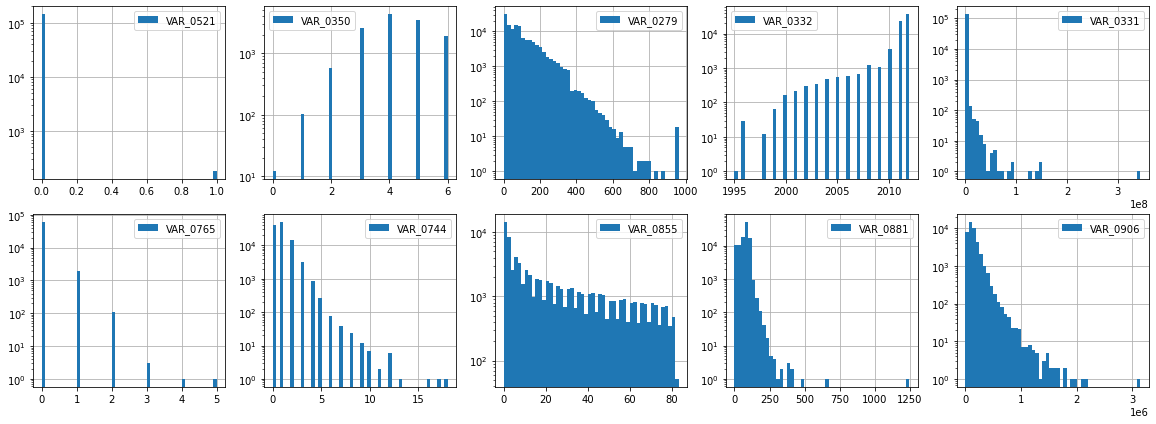

In [7]:
fig, ax = plt.subplots(2,5,figsize=(20,7))

ax = ax.ravel()

for k, hist_list in enumerate(cols_to_plot):
    
    for j, col in enumerate(hist_list):       
        i = j + 5*k
        (dfi_a[col] if k<1 else dfi_b[col]).plot.hist(ax=ax[i],bins=50,log=True,legend=col)
        ax[i].grid(); ax[i].set_axisbelow(True); ax[i].set_ylabel('')

Mostly exponential or even more steeply falling distributions (notice the logarithmic scale here as well). And no outliers; an excess at the max value of 960 in the distribution of VAR_0279 (and ~15 other neighbouring columns) might correspond to a saturation threshold of whatever measurement was performed there. The VAR_0332 column (and two other columns) contains a year info. OK, nothing more to say, we're done with this part.

Let's now move to the large positive limits: 99, 999, 9999 and 9999999999. Let's remove these numbers from the corresponding columns, then make similar summary statistics plots:

In [8]:
dfi_max = dfi.max()

limits = [99, 999, 9999, 999999999]

cols9 = []
dfi9 = []

for i, limit in enumerate(limits):
    
    cols9.append(dfi_max[dfi_max == limit].index)
    print(len(cols9[i]),'columns with max =',limit)
    
    dfi9.append( dfi[cols9[i]][dfi[cols9[i]] < limit])

458 columns with max = 99
238 columns with max = 999
159 columns with max = 9999
257 columns with max = 999999999


Lots of columns, these will be busy plots. Let's order the columns by the increasing median of their distributions, and let's also set the scale on the y axis to linear (logarithmic) for the first (last) two limits:

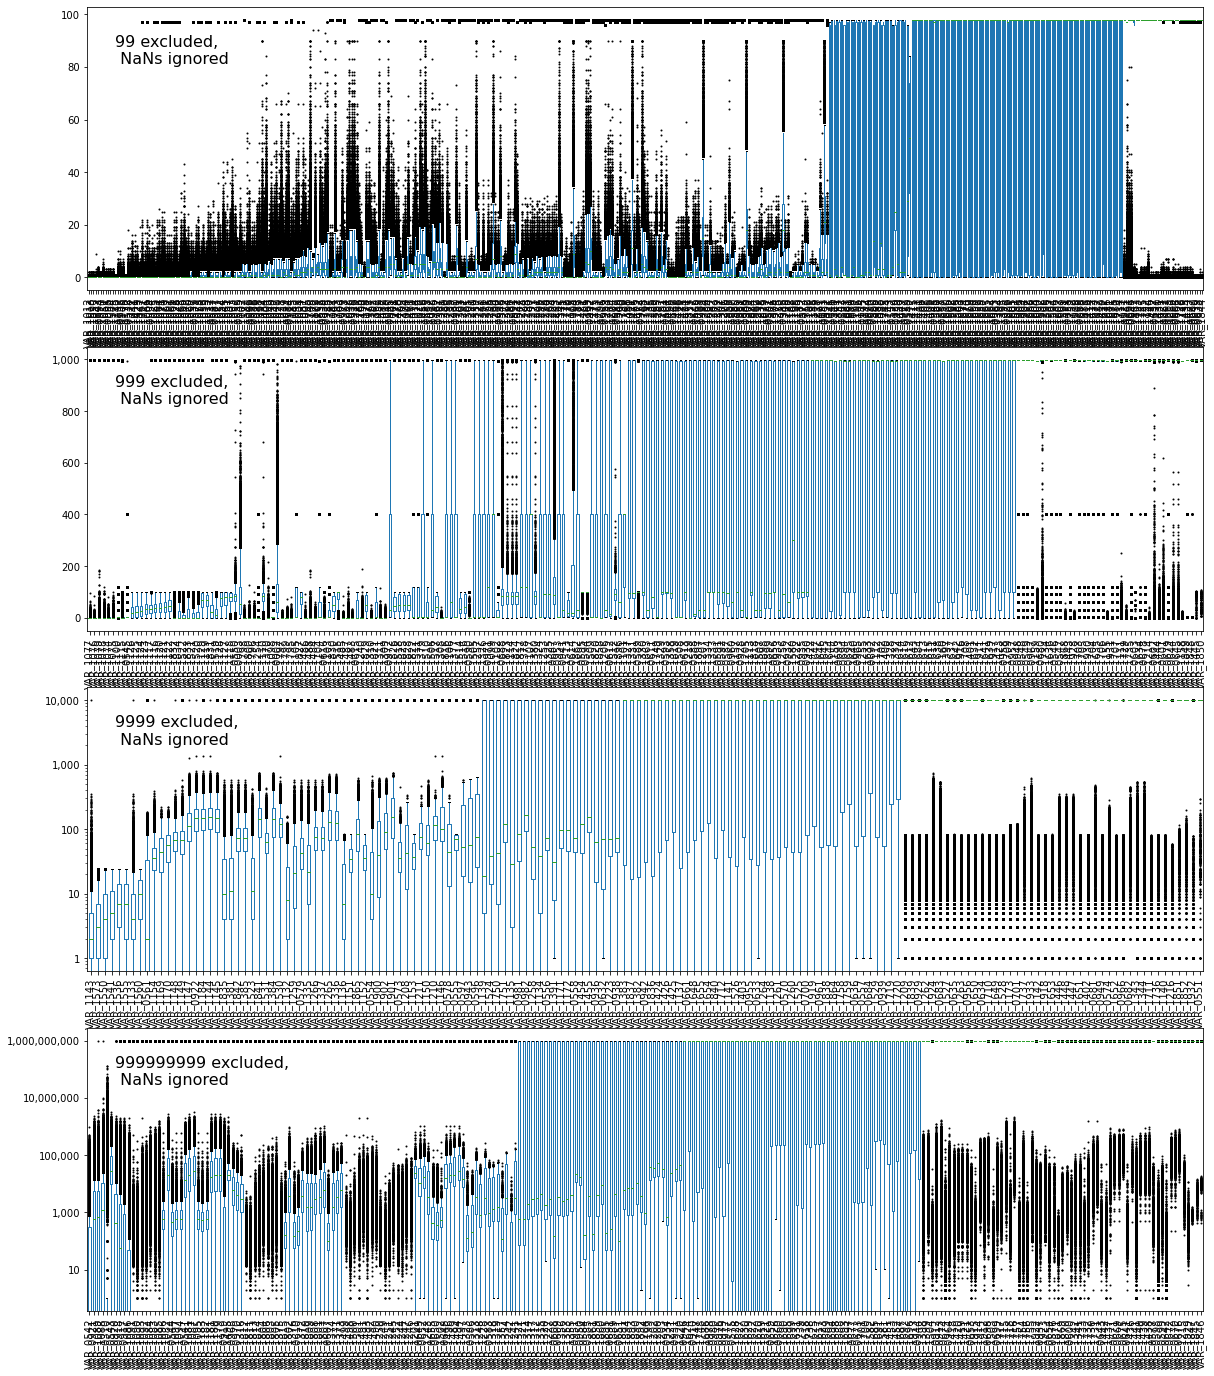

In [9]:
fig, ax = plt.subplots(4,1,figsize=(20,24))

cols9_sorted = []

for i in range(len(ax)):
    
    cols9_sorted.append( dfi9[i].mean().sort_values().index)
    
    dfi9[i][cols9_sorted[i]].plot.box(ax=ax[i],flierprops=dict(markersize=1))
        
    if i > 1: ax[i].set_yscale('log')
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 90)
    ax[i].text(0.025, 0.8, str(limits[i]) + ' excluded,\n NaNs ignored', transform=ax[i].transAxes,fontsize=16)

Ha! Quite a surprise! Eventhough we removed the max values from the subsamples, we still can see entries close to those values. This means that for most of the columns there is more that one value populating the region far from the continuous spectrum at the lower end. We have already seen a few of such cases in Sec. 3.4 of the [previous notebook](./data_wrangling.ipynb#3.4) while scanning low-multiplicity unique entries ( [0,1, 97, 98, 99], [998 999   1 400], etc). What's surprising is that this pattern is very common in the entire dataset. Also, that those high numbers probably do not represent missing values as we originally assumed. In the plots, the columns are ordered by the increasing value of the median, so we expect a small frequency of these extreme numbers on the left side of the horizontal axis and their higher frequency on the right side of the axis. That's also the reason why the blue boxes, representing the quantiles, are drifting from the left to the right of the plots.

So what are these patters? Let's count the number of columns with each particular configuration of the outstanding high numbers. We will select them by scanning a region not smaller than ~90% of the original max value for each of the previously selected samples containing 99, 999, 9999, 999999999:

In [10]:
from collections import Counter

thres = [90,990,9*10**3,9*10**8]

for i in range(len(limits)):
    
    print('\n{} (all >{}):\n'.format(limits[i],thres[i]))
    
    nseq = []
    for col in cols9[i]:
        nseq.append(str(sorted(list(dfi[col][dfi[col] > thres[i]].unique()))))
    
    for n, seq in sorted(zip(Counter(nseq).values(),Counter(nseq).keys()),key = lambda c: c[0],reverse=True): 
        print(n,seq)


99 (all >90):

164 [98, 99]
146 [97, 98, 99]
91 [99]
39 [97, 99]
6 [96, 97, 98, 99]
4 [96, 99]
2 [96, 97, 99]
2 [94, 99]
2 [94, 96, 97, 98, 99]
1 [93, 99]
1 [96, 98, 99]

999 (all >990):

88 [997, 998, 999]
40 [998, 999]
27 [995, 996, 997, 998, 999]
19 [997, 999]
12 [994, 999]
10 [996, 997, 998, 999]
9 [999]
9 [994, 997, 998, 999]
7 [995, 996, 998, 999]
5 [994, 998, 999]
3 [995, 996, 997, 999]
3 [994, 995, 996, 997, 999]
3 [994, 996, 997, 998, 999]
2 [994, 995, 996, 997, 998, 999]
1 [995, 999]

9999 (all >9000):

56 [9996, 9998, 9999]
32 [9994, 9998, 9999]
18 [9996, 9999]
14 [9998, 9999]
12 [9994, 9999]
9 [9994, 9996, 9998, 9999]
8 [9999]
4 [9994, 9996, 9997, 9998, 9999]
2 [9996, 9997, 9998, 9999]
1 [9990, 9996, 9999]
1 [9994, 9995, 9996, 9998, 9999]
1 [9995, 9996, 9998, 9999]
1 [9990, 9996, 9998, 9999]

999999999 (all >900000000):

197 [999999996, 999999997, 999999998, 999999999]
14 [999999996, 999999997, 999999999]
7 [999999994, 999999996, 999999997, 999999998, 999999999]
7 [9999999

A lot of them. And for sure they are not missing values, so we won't replace them, as we did earlier for negative numbers (-99999 $\rightarrow$ -1).

The remaining question is how are those high numbers related to the rest of the spectra? Is the target separation continuous in the entire range of the variables? Let's check it with a few examples. Let's plot the spectra for the most left and most right columns in the box plots above, for each of the 99, 999, 99999, 10^9-1 groups. First, let's prepare a few plotting functions:

In [11]:
xsiz = 10
ysiz = 3

def plot_2_lin(cols,nbins=20):
    
    fig, ax = plt.subplots(1,2,figsize=(xsiz,ysiz),sharey=True)

    for i,col in enumerate(cols):
    
        dfi[col].plot.hist(ax=ax[i],bins=nbins);

        ax[i].grid(); ax[i].set_axisbelow(True)
        ax[i].set_xlabel(col,fontsize=13)
        if i == 0: ax[i].set_ylabel('N entries',fontsize=13)   
        
        
def plot_2_log(cols,nbins=20,offset=1):

    fig, ax = plt.subplots(1,2,figsize=(xsiz,ysiz),sharey=True)
    
    for i,col in enumerate(cols):
    
        logbins = np.logspace(np.log10(1),np.log10(dfi[col].max()+offset), nbins)
    
        (dfi[col]+offset).plot.hist(ax=ax[i],bins=logbins);

        ax[i].grid(); ax[i].set_axisbelow(True)
        ax[i].set_xscale('log'); ax[i].set_yscale('log');

        ax[i].set_xlabel(col,fontsize=13)
        if i == 0: ax[i].set_ylabel('N entries (log scale)',fontsize=13)
    
        ax[i].set_ylim(bottom = 0.8,top = 10**6)
        
def plot_2_target(cols,nbins=20,offset=1):

    fig, ax = plt.subplots(1,2,figsize=(xsiz,ysiz),sharey=True)
    
    for i,col in enumerate(cols):
    
        df_tmp = pd.concat((dfi[col],y),axis=1)

        histbins = np.linspace(0,dfi[col].max(), nbins)
        bins = pd.cut(df_tmp[col],histbins)
        yavg = df_tmp.groupby(bins)['target'].mean().values; yavg = np.nan_to_num(yavg)
    
        bincenter = np.mean(np.vstack([histbins[:-1],histbins[1:]]), axis=0)
        ax[i].hist(bincenter,weights=yavg,bins=histbins)

        ax[i].grid(); ax[i].set_axisbelow(True)
        ax[i].set_xlabel(col,fontsize=13)
        if i == 0: ax[i].set_ylabel('Target average',fontsize=13)
        ax[i].hlines(y.mean(),-1,histbins[-1],linewidth=1,linestyle='--',color='r');          

def plot_2_target_log(cols,nbins=20,offset=1):

    fig, ax = plt.subplots(1,2,figsize=(xsiz,ysiz),sharey=True)
    
    for i,col in enumerate(cols):
    
        df_tmp = pd.concat((dfi[col]+offset,y),axis=1)
        
        logbins = np.logspace(np.log10(1),np.log10(dfi[col].max()+offset), nbins)

        bins = pd.cut(df_tmp[col],logbins)
        yavg = df_tmp.groupby(bins)['target'].mean().values; yavg = np.nan_to_num(yavg)
    
        bincenter = np.mean(np.vstack([logbins[:-1],logbins[1:]]), axis=0)
        ax[i].hist(bincenter,weights=yavg,bins=logbins)

        ax[i].grid(); ax[i].set_axisbelow(True)
        ax[i].set_xscale('log')
        ax[i].set_xlabel(col,fontsize=13)
        if i == 0: ax[i].set_ylabel('Target average',fontsize=13)
        ax[i].hlines(y.mean(),-1,logbins[-1],linewidth=1,linestyle='--',color='r');   

Let's start from the sample containing the highest maximum value, 10^9-1, and plot the variable distribution for two different columns, in which entries dominate the lower or the higher end of the spectrum:

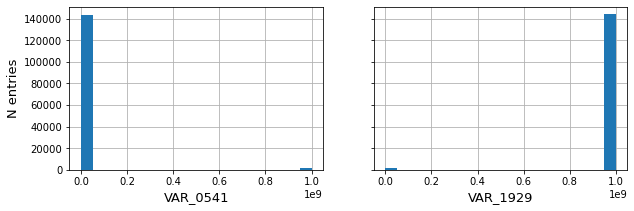

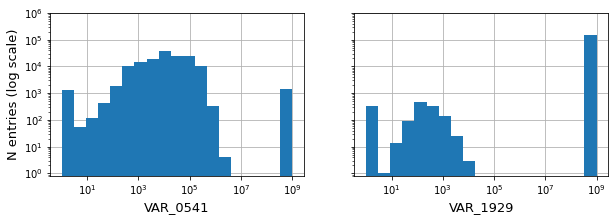

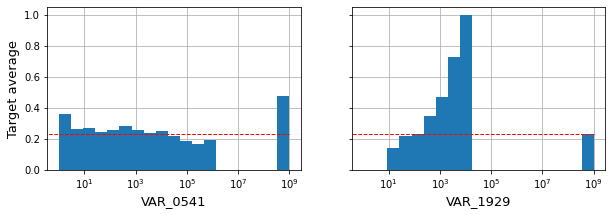

In [12]:
cols = [cols9[3][1],cols9[3][-1]]

plot_2_lin(cols); plot_2_log(cols); plot_2_target_log(cols)

The first row shows the distribution in the linear scale, however the available range is so wide that we need double-log plots to see some structure (middle row). The differential average target response in the bins of the previous plots is presented in the bottom row. Interestingly, the target response does not change smoothly, but rather shows a jump when moving from the low end to the high end of the spectrum.

Let's do the same plots for the columns with the highest maximum value of 9999:

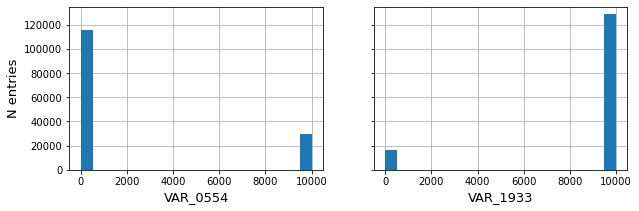

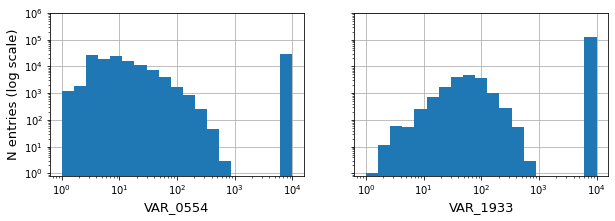

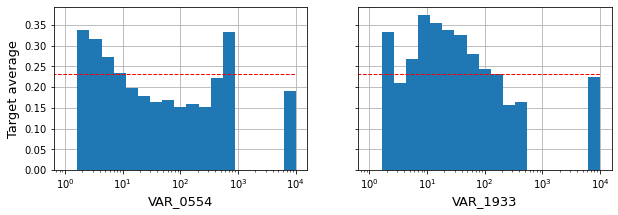

In [13]:
cols = [cols9[2][1],cols9[2][-1]]

plot_2_lin(cols); plot_2_log(cols); plot_2_target_log(cols)

The conclusions are the same. Let's also plot similar distributions for the 999 max value this we can use only the linear scale:

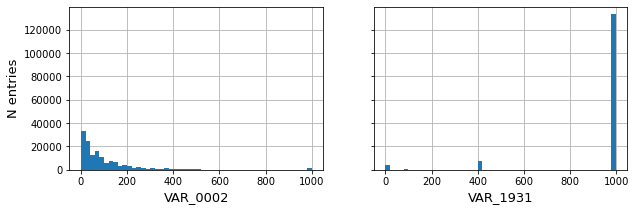

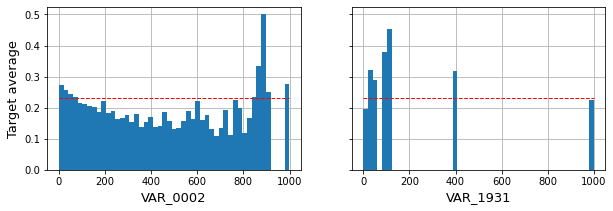

In [14]:
cols = [cols9[1][0],cols9[1][-1]]

plot_2_lin(cols,50); plot_2_target(cols,50)

And finally for two columns with the 99 max value:

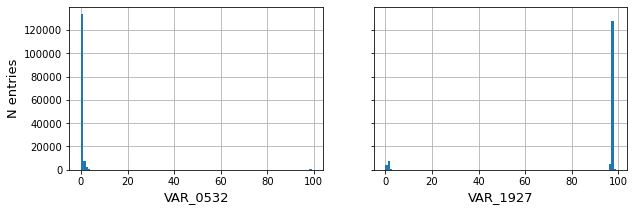

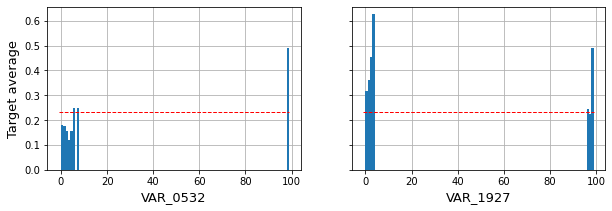

In [15]:
cols = [cols9[0][0],cols9[0][-1]]

plot_2_lin(cols,100); plot_2_target(cols,100)

Overall the same picture, in each investigated column the target variable behaves differently in the continuous low-end and discrete high-end parts of the spectra. What do we do with this? Such a situation is not an issue for customer churn modeling with ensemble-based classifiers, such as Random Forest, Extreme Gradient Boosting, etc. On the other hand, the performance of regression-based models (in our case Logistic Regression) will suffer, as they assume a linear dependence of customer response on variables in play, which is clearly not the case here. 

__talk to Rajiv:__

- what about SVM and KNN? 

- and data standarization for PCA, NN?

- plus, what FE can we do?:

    - split low/high ends into separate variables?

    - transform x -> log(x), to at least shorten the gap between low/high parts?

### 2. Float-type features<a id='2'></a>

In [16]:
dff = pd.read_csv("./data/work_floats.csv",index_col='ID',low_memory=False).convert_dtypes()
dpf = pd.read_csv("./data/pred_floats.csv",index_col='ID',low_memory=False).convert_dtypes()

dff.shape, dpf.shape

((145231, 10), (145232, 10))

Our float variables contain 3 types of differently encoded missing values. Since there are only 10 such variables, let's plot them all and print their missing values. When plotting, let's temporarily replace -1  with -10, to visually better separate them from the non-zero spectra:

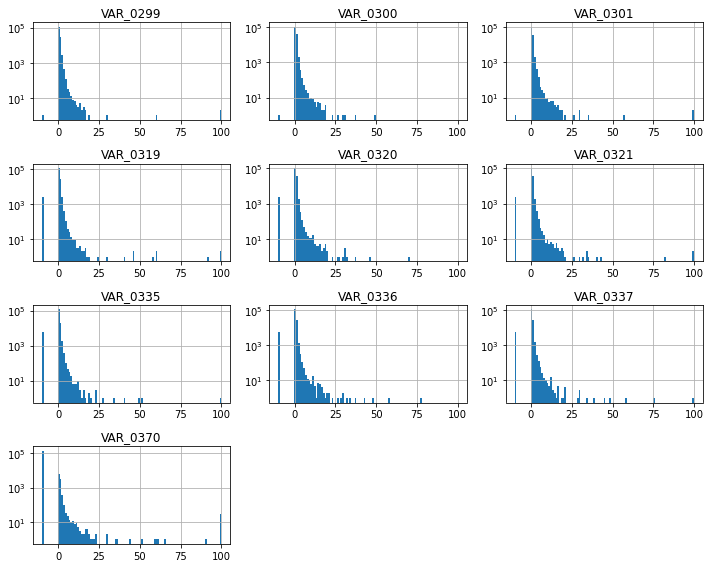

In [17]:
dff.replace(-1,-10).hist(figsize=(10,8),bins=101,range=(-10,100),log=True)
plt.tight_layout();

In [18]:
fmiss = dff.agg([lambda x: x.isna().sum(),lambda x: (x == -1).sum(),lambda x: (x == 99).sum()],axis=0)
fmiss.index = ['n( NaN)','n( -1)', 'n( 99)']
fmiss.T

,n( NaN),n( -1),n( 99)
VAR_0299,918,1,2
VAR_0300,918,1,0
VAR_0301,918,1,2
VAR_0319,918,2521,2
VAR_0320,918,2521,0
VAR_0321,918,2521,2
VAR_0335,918,5944,1
VAR_0336,918,5944,0
VAR_0337,918,5944,1
VAR_0370,918,134450,28


In all the columns NaNs are missing in 918 rows, they correspond to the lack of data in the same way as -1 does in the plots above. But does the target variable behave differently for rows containing each of those values?:

In [19]:
print('\t\t   target average')
print('rows with   NaNs:\t', y[(dff.isna()).sum(axis=1) > 0].mean().round(4).values[0])
print('rows with     -1:\t', y[(dff ==  -1).sum(axis=1) > 0].mean().round(4).values[0])
print('the whole sample:\t', y.mean().round(4).values[0])

		   target average
rows with   NaNs:	 0.2309
rows with     -1:	 0.2346
the whole sample:	 0.2325


2% relative difference and 1% difference w.r.t. the overall sample. It seems like it might be somewhat beneficial to replace all the instances of NaN by a numerical value that is different from -1, e.g. by -2. We will do it in the next section. As for the number 99, it is significantly present only in the last column, it might represent a saturation threshold above which no values can be measured, so we will leave it unchanged. 

### 3. String-type features<a id='3'></a>

In [20]:
dfc = pd.read_csv("./data/work_strings.csv",index_col='ID',low_memory=False)
dpc = pd.read_csv("./data/pred_strings.csv",index_col='ID',low_memory=False)
 
dfc.shape,dpc.shape

((145231, 17), (145232, 17))

Let's print again the first few rows of the string dataset and the number of unique entries, NaNs and -1 digits per column: 

In [21]:
dfc.head()

,VAR_0001,VAR_0005,VAR_0200,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
ID,,,,,,,,,,,,,,,,,
2,H,C,FT LAUDERDALE,FL,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
4,H,B,SANTEE,CA,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
5,H,C,REEDSVILLE,WV,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
7,H,C,LIBERTY,TX,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
8,R,N,FRANKFORT,IL,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH


In [22]:
cmiss = dfc.agg([lambda x: x.nunique(dropna=False),lambda x: x.isna().sum(),lambda x: (x == '-1').sum()])
cmiss.index = ['n unique','n( NaN)','n( -1)']
cmiss.T

,n unique,n( NaN),n( -1)
VAR_0001,3,0,0
VAR_0005,4,0,0
VAR_0200,12386,60,0
VAR_0237,46,56,0
VAR_0274,58,918,327
VAR_0283,8,918,4960
VAR_0305,9,918,2907
VAR_0325,10,918,13574
VAR_0342,51,918,30969
VAR_0352,5,918,2521


Let's separately investigate the following:

1) one column with more than 12k names of the cities: VAR_0200 (fully filled),

2) two columns with profession names: VAR_0404 and VAR_0493 (more than 90% empty),

3) two columns with US state codes: VAR_0237 and VAR_0274 (fully and almost fully filled),

4) remaining 12 columns with low-multipicity letter-encoded categorical variables (~15% to fully filled)

__Ad 1:__ As said earlier, we will convert city names to a numerical variable with city populations, this will be done in the next chapter dedicated to feature engineering.

__Ad 2:__ More than 90% missing values in columns VAR_0404 and VAR_0493 and a time-consuming NLP problem to convert professions to numerical variables. Is is worth is? Let's check if there is any visible difference between the professions when they are separated by the target variable. First, let's prepare a function that will show word clouds for the two target values (1 and 0):

In [23]:
from wordcloud import WordCloud, STOPWORDS

def show_most_freqent_words(col):
    words1 = ''
    for val in dfc[col][y['target'] == 1].astype('str'):
        words1 = words1 + ' ' + val
        
    wordcloud1 = WordCloud(width = 1200, height = 600, #background_color ='white',# stopwords = STOPWORDS, 
                           max_words=200, #prefer_horizontal = 1,
                           min_font_size = 30,            
                           max_font_size = 100, #relative_scaling = 0,
                           min_word_length = 3,random_state=123).generate(words1) 
    
    words0 = ''
    for val in dfc[col][y['target'] == 0].astype('str'):
        words0 = words0 + ' ' + val
        
    wordcloud0 = WordCloud(width = 1200, height = 600, #background_color ='white',# stopwords = STOPWORDS, 
                           max_words=200, #prefer_horizontal = 1,
                           min_font_size = 30,
                           max_font_size = 100, #relative_scaling = 0,
                           min_word_length = 3,random_state=123).generate(words0) 
                        
        
    fig, ax = plt.subplots(1,2,figsize=(16,8),facecolor=None)
    
    ax[0].imshow(wordcloud1); ax[0].axis("off"); ax[0].set_title('target == 1',fontsize=20,color='r')
    ax[1].imshow(wordcloud0); ax[1].axis("off"); ax[1].set_title('target == 0',fontsize=20,color='r')

    fig.suptitle(col,fontsize=20,color='r')
    fig.tight_layout(rect=[0, 0.03, 1, 1.3]);

Then, let's run it for each of the two columns:

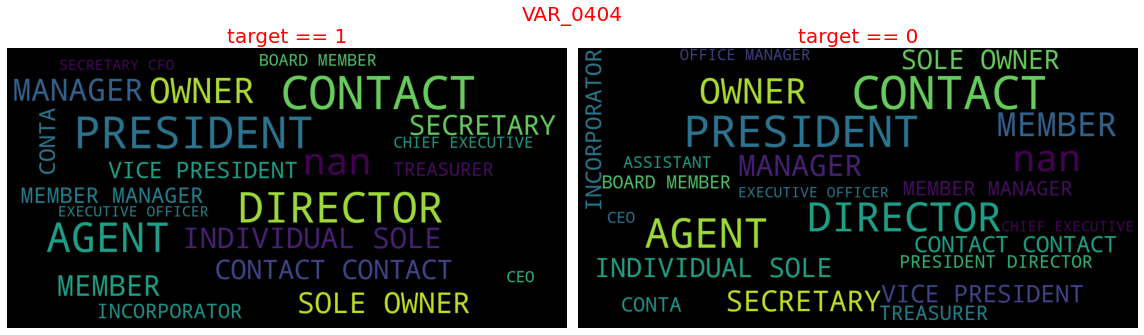

In [24]:
show_most_freqent_words('VAR_0404')

Contact, Director, President, Owner, Agent, Secretary, Sole Owner, etc. - the same professions are present in the VAR_0404 column for both target values.

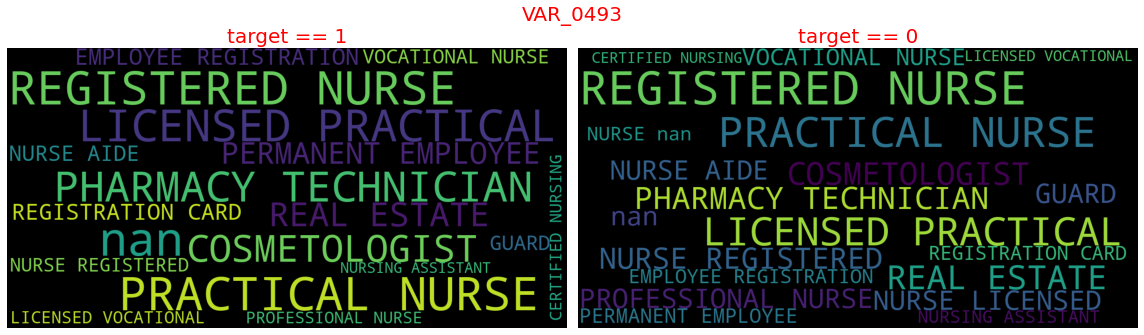

In [25]:
show_most_freqent_words('VAR_0493')

Registered Nurse, Practical Nurse, Pharmacy Technician, Cosmetologist, Licensed Practical, etc. - the same professions for both target values also for VAR_0493. It doesn't seem that the profession names can clearly separate the target so we will ignore both columns in the further analysis. Let's remove them from the dataset now:

In [26]:
dfc = dfc.drop(['VAR_0404','VAR_0493'],axis=1)
dpc = dpc.drop(['VAR_0404','VAR_0493'],axis=1)

dfc.shape,dpc.shape

((145231, 15), (145232, 15))

__Ad 3:__ Let's look into the state information given in columns VAR_0237 and VAR_0274. Can we understand why the state info appears in the dataset twice? Let's check the difference between the two columns, in particular, why the numbers of unique values for those columns are 46 or 58, instead of the actual 50 states + DC. Let's do some printout:

In [27]:
col1 = 'VAR_0237'
col2 = 'VAR_0274'

states1 = list(set(list(dfc[col1].unique()) + list(dpc[col1].unique()) ))
states2 = list(set(list(dfc[col2].unique()) + list(dpc[col2].unique()) ))

What's the common part?:

In [28]:
states12 = [i for i in states1 if i in states2]

print(len(states12),'in both:',states12)

47 in both: ['LA', nan, 'DC', 'TX', 'OK', 'MD', 'ND', 'IN', 'UT', 'AK', 'OH', 'AZ', 'SC', 'KY', 'MT', 'WY', 'PA', 'GA', 'VA', 'WA', 'AR', 'WV', 'WI', 'CA', 'ID', 'KS', 'CT', 'NE', 'SD', 'NV', 'MS', 'MN', 'TN', 'DE', 'AL', 'NC', 'IL', 'MI', 'OR', 'MO', 'NY', 'IA', 'FL', 'CO', 'HI', 'NJ', 'NM']


The NaNs + 46 out of 51 states (DC included). What are the exclusive parts?:

In [29]:
states1_only = [i for i in states1 if i not in states2]
states2_only = [i for i in states2 if i not in states1]

print(len(states1_only),'only in',col1,':',states1_only)
print(len(states2_only),'only in',col2,':',states2_only)

0 only in VAR_0237 : []
11 only in VAR_0274 : ['GS', 'VT', 'NH', 'ME', 'RN', 'MA', 'RR', '-1', 'RI', 'EE', 'PR']


In [30]:
# RI, ME, MA, NH, VT - Rode Island, Maine, Massachusetts, New Hampshire, Vermont 
# PR - Puerto Rico
# EE, GS, RR, RN - ?

The first column (VAR_0237) contains the codes for only 46 states, excluding 5 states in New England. The second column (VAR_0274) contains all the 51 states, plus Puerto Rico, plus additional 4 abbreviations that are difficult to decipher, plus the -1 digit. It could be that the first column corresponds to the states in which the data was collected (everywhere in the US except New England), while the second column contains information about the patient's place of birth (hence PR as Puerto Rico, EE as e.g. Estonia, -1, etc). Btw. is Boston, MA among the cities listed in the column VAR_0200?:

In [31]:
dfc['VAR_0200'].str.contains('Boston').sum()

0

Nope. What about Providence, RI?:

In [32]:
dfc['VAR_0200'].str.contains('Providence').sum()

0

Nope, it's not there either. So, most probably cities in the VAR_0200 column are related to the states in the VAR_0237 column. We probably also have a zip code column hidden in the dataset. Anyway, regardless of the interpretation, let's find out how often both state columns have the same code:

In [33]:
(dfc[col1] == dfc[col2]).mean().round(2)

0.68

Almost 70% of the rows have the same abbrevation. Is there any difference in the target variable if the two columns differ/are the same?:

In [34]:
df_tmp = pd.concat((dfc[col1] == dfc[col2],y),axis=1)
df_tmp.columns = ['the same:','target avg:']
print(df_tmp.groupby('the same:').mean().round(3))

print('\nFull sample:    ',y.mean()[0].round(3))

           target avg:
the same:             
False            0.235
True             0.231

Full sample:     0.233


A minimal difference: only 1% change in the target variable relative to the overall sample. But 1% is better than nothing, so will not ignore the second columns yet. For the further analysis, we will apply a one-hot encoding to the VAR_0237 column and replace the VAR_0274 column with the condition VAR_0237 == VAR_0274. 

Let's finish with showing how the target variable looks for each state in the column VAR_0237?:

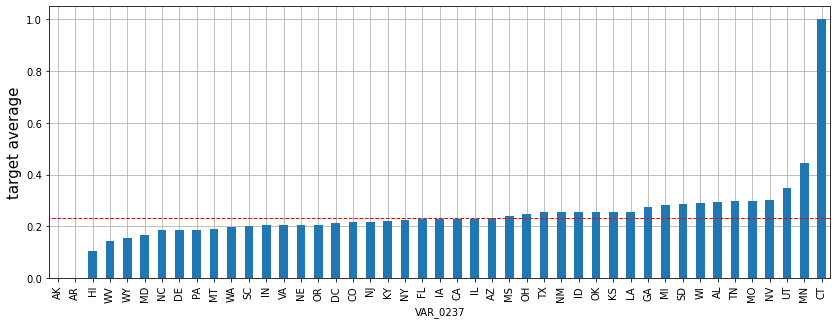

In [35]:
df_tmp = pd.concat((dfc[col1],y),axis=1)
df_tmp.groupby(col1)['target'].mean().sort_values().plot(kind='bar',figsize=(14,5));

plt.hlines(y.mean(),-1,60,linewidth=1,linestyle='--',color='r')
plt.grid(); plt.gca().set_axisbelow(True)
plt.ylabel('target average',fontsize=15);

Not bad, the state information has a potential to separate the target variable.

__Ad 4:__ Among 12 columns with low-multipicity letter-encoded variables, there is one column (VAR_0342) that has 50 unique values and 11 columns with less than 10 values each. Let's inspect the VAR_0342 column first. Let's plot the average target value per each unique entry in that column, together with the number of rows corresponding to these entries:

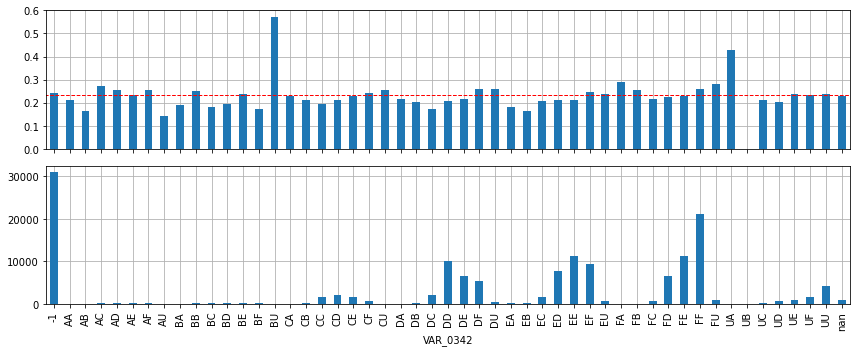

In [36]:
fig, ax = plt.subplots(2,1,figsize=(12,5),sharex=True)

col = 'VAR_0342'
df_tmp = pd.concat((dfc[col].astype('str'),y),axis=1)

df_tmp.groupby(col).mean().plot.bar(ax=ax[0],legend=None)
df_tmp.groupby(col).count().plot.bar(ax=ax[1],legend=None)

for i in range(2):
    ax[i].grid(); ax[i].set_axisbelow(True)

ax[0].hlines(y.mean(),-10,100,linewidth=1,linestyle='--',color='r')

fig.tight_layout()

The variable contains 50 unidentified codes, they are the XY combinations with X/Y = [A,B,C,D,E,F,U]. Interstingly a clear modulation in the number of entries is visible, with the letters D-F being the most populous for both X and Y (bottom plot). This is an interesting observation, but has no effect on our studies. It's good to see a variation of the average target response with the XY codes (top plot), so in the next section on feature engineering we will one-hote encoding to covert these string variables into numerical variables.

Finally, let's inspect te variables with at most 10 unique values and let's plot the average target value for each unique entry for each column:

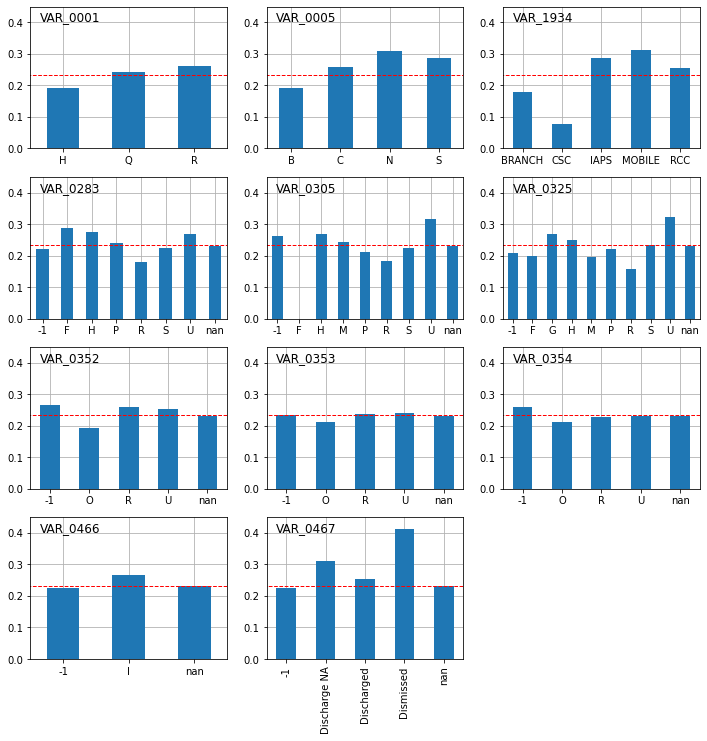

In [37]:
cols_c = dfc.columns[dfc.nunique()<40]

fig, ax = plt.subplots(4,3,figsize=(12,12))

ax = ax.ravel()
ax[11].set_axis_off()

for i,col in enumerate(cols_c):
    
    # change the order to have non-nan columns in the first row
    j = i if i < 2 else i + 1
    if i == 10:
        j = 2

    df_tmp = pd.concat((dfc[col].astype('str'),y),axis=1)
    df_tmp.groupby(col).mean().plot.bar(ax=ax[j],legend=None)
 
    ax[j].grid(); ax[j].set_axisbelow(True)
    ax[j].set_xlabel('')
    ax[j].text(0.05, 0.9, col, transform=ax[j].transAxes,fontsize=12)
    if j < 10 : ax[j].tick_params(axis='x', labelrotation=0)
        
    ax[j].set_ylim(top = 0.45)   
    ax[j].hlines(y.mean(),-10,100,linewidth=1,linestyle='--',color='r');

Nice variation, especially for the three columns that have no missing values (top row), also for those in the second row (F-U entries), and in the last plot. In the next section we will apply one-hot encoding to all of them. Moreover, one can notice that the average target value is slightly different for the -1 and nan entries, so we will one-hot encode them as separate columns. 

### 4. Datetime-type features<a id='4'></a>

Let's load the data parsing the approperiate datetime format, which we saw in [Sec. 4.3](./data_wrangling.ipynb#4.3) of the previous notebook:

In [38]:
dft = pd.read_csv("./data/work_datetimes.csv",index_col='ID',low_memory=False)
dpt = pd.read_csv("./data/pred_datetimes.csv",index_col='ID',low_memory=False)

for col in dft.columns:
    dft[col] = pd.to_datetime(dft[col],format='%d%b%y:%H:%M:%S')
    dpt[col] = pd.to_datetime(dpt[col],format='%d%b%y:%H:%M:%S')
    
dft.shape,dpt.shape

((145231, 16), (145232, 16))

In [39]:
dft.dtypes

VAR_0073    datetime64[ns]
VAR_0075    datetime64[ns]
VAR_0156    datetime64[ns]
VAR_0157    datetime64[ns]
VAR_0158    datetime64[ns]
VAR_0159    datetime64[ns]
VAR_0166    datetime64[ns]
VAR_0167    datetime64[ns]
VAR_0168    datetime64[ns]
VAR_0169    datetime64[ns]
VAR_0176    datetime64[ns]
VAR_0177    datetime64[ns]
VAR_0178    datetime64[ns]
VAR_0179    datetime64[ns]
VAR_0204    datetime64[ns]
VAR_0217    datetime64[ns]
dtype: object

The format is recognized correctly. Let's print a few rows:

In [40]:
dft.dropna().head()

,VAR_0073,VAR_0075,VAR_0156,VAR_0157,VAR_0158,VAR_0159,VAR_0166,VAR_0167,VAR_0168,VAR_0169,VAR_0176,VAR_0177,VAR_0178,VAR_0179,VAR_0204,VAR_0217
ID,,,,,,,,,,,,,,,,
249,2012-10-01,2009-11-02,2011-05-05,2011-06-05,2012-03-01,2012-02-02,2010-04-05,2012-05-21,2011-04-20,2012-04-13,2010-04-05,2012-05-21,2012-03-01,2012-04-13,2014-02-01 00:16:00,2012-10-03 02:00:00
17628,2012-02-26,2011-09-02,2011-09-02,2012-03-08,2011-12-12,2012-01-25,2011-09-02,2012-03-08,2011-12-15,2012-02-13,2011-09-02,2012-03-08,2011-12-15,2012-02-13,2014-01-30 22:44:00,2012-05-11 02:00:00
23801,2012-08-07,2010-07-20,2010-12-01,2011-04-29,2011-02-04,2011-02-07,2010-12-01,2011-05-14,2011-04-15,2011-04-15,2010-12-01,2011-05-14,2011-04-15,2011-04-15,2014-02-01 01:02:00,2012-10-23 02:00:00
31786,2012-02-28,2010-12-14,2011-10-10,2012-02-11,2012-01-06,2012-01-26,2011-06-06,2012-02-07,2011-12-23,2011-12-08,2011-06-06,2012-02-11,2012-01-06,2012-01-26,2014-01-30 22:53:00,2012-05-17 02:00:00
65173,2012-10-27,2009-03-07,2011-11-21,2012-10-10,2012-07-27,2012-07-31,2012-04-10,2012-10-19,2012-06-15,2012-10-01,2011-11-21,2012-10-19,2012-07-27,2012-10-01,2014-02-01 01:24:00,2012-10-30 02:00:00


and recall the fraction of missing values per column:

In [41]:
(dft.isna().sum()*100/dft.shape[0]).round(2).astype('str') + ' %'

VAR_0073    69.63 %
VAR_0075     0.04 %
VAR_0156    95.96 %
VAR_0157    99.37 %
VAR_0158    98.56 %
VAR_0159    95.96 %
VAR_0166     90.2 %
VAR_0167    98.23 %
VAR_0168    92.62 %
VAR_0169     90.2 %
VAR_0176    87.93 %
VAR_0177    97.69 %
VAR_0178    91.69 %
VAR_0179    87.93 %
VAR_0204     0.04 %
VAR_0217     0.04 %
dtype: object

Let's also print the min and max date for each column, and the difference between them (in hours and in years):

In [42]:
diff_d = lambda x: round((x.max() - x.min())/np.timedelta64(1, 'D'))
diff_y = lambda x: round((x.max() - x.min())/np.timedelta64(1, 'Y'))

t_range = dft.apply(['min','max',diff_d, diff_y])
t_range.index = ['T min','T max', 'dT( days)','dT( years)']
t_range.T

,T min,T max,dT( days),dT( years)
VAR_0073,2008-01-02 00:00:00,2012-10-31 00:00:00,1764,5
VAR_0075,2001-01-01 00:00:00,2012-11-01 00:00:00,4322,12
VAR_0156,2008-04-11 00:00:00,2012-10-29 00:00:00,1662,5
VAR_0157,2008-10-17 00:00:00,2012-10-31 00:00:00,1475,4
VAR_0158,2008-09-30 00:00:00,2012-10-29 00:00:00,1490,4
VAR_0159,2008-09-23 00:00:00,2012-10-29 00:00:00,1497,4
VAR_0166,2002-07-30 00:00:00,2012-10-30 00:00:00,3745,10
VAR_0167,2005-02-12 00:00:00,2012-10-30 00:00:00,2817,8
VAR_0168,1999-12-31 00:00:00,2012-11-01 00:00:00,4689,13
VAR_0169,2002-07-30 00:00:00,2012-11-01 00:00:00,3747,10


Interesting. Column 204 spans the time interval of 2 days, from Jan 29 to Feb 1 in the year 2014, column 217 covers a period of one year in 2012, all the other columns span multiple years (from 4 to 13) and have the latest date in 2012. 

What's inside column 204? Let's plot the hour of the day versus the day of the month for the data in this column: 

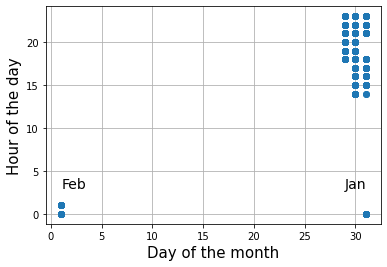

In [43]:
plt.plot(dft['VAR_0204'].dt.day, dft['VAR_0204'].dt.hour,'o')
plt.grid()
plt.xlabel('Day of the month',fontsize=15)
plt.ylabel('Hour of the day',fontsize=15)
plt.text(29, 3, 'Jan',fontsize=14)
plt.text( 1, 3, 'Feb',fontsize=14);

The data covers hours from about 2 PM and about 2 AM, regardless of the day (notice the jump from Jan to Feb on the day axis). This might be somebody's 12-hour working day or a shift in a hospital. 

How is column 204 related to other columns? To anwer this question we will convert the data format from absolute dates to a time difference w.r.t. the starting date of column 204:

In [44]:
dft_diff = dft - dft['VAR_0204'].min()
dpt_diff = dpt - dpt['VAR_0204'].min() # also for the pred sample

dft_diff.head()

,VAR_0073,VAR_0075,VAR_0156,VAR_0157,VAR_0158,VAR_0159,VAR_0166,VAR_0167,VAR_0168,VAR_0169,VAR_0176,VAR_0177,VAR_0178,VAR_0179,VAR_0204,VAR_0217
ID,,,,,,,,,,,,,,,,
2,NaT,-814 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 02:31:00,-814 days +07:15:00
4,-513 days +05:15:00,-812 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2 days 05:26:00,-485 days +07:15:00
5,NaT,-779 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 20:26:00,-779 days +07:15:00
7,NaT,-1225 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2 days 05:22:00,-455 days +07:15:00
8,NaT,-838 days +05:15:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:46:00,-838 days +07:15:00


Let's check now the relation between column 204 and column 217 (with the second shortest time span):

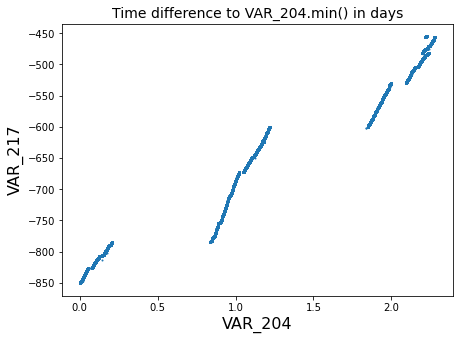

In [45]:
tunit = np.timedelta64(1,'D')

plt.figure(figsize=(7,5))
plt.scatter(dft_diff['VAR_0204']/tunit,dft_diff['VAR_0217']/tunit,s=1)

plt.title('Time difference to VAR_204.min() in days',fontsize=14)
plt.xlabel('VAR_204',fontsize=16)
plt.ylabel('VAR_217',fontsize=16);

Almost 1:1 correspondence! It's possible that during three days in 2014 (VAR_204), somebody was analyzing chronologically-ordered data recorded for ~400 days in the year 2012 (VAR_217). In any case, the VAR_204 variable seems redundant and could be removed from the dataset.

Now let's recall that the maximum date for the remaining columns corresponds to 2012 as well. Is there any relation between these columns and the column VAR_217? Let's inspect it by plotting the time difference between each of the remaining columns and VAR_217:

/data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


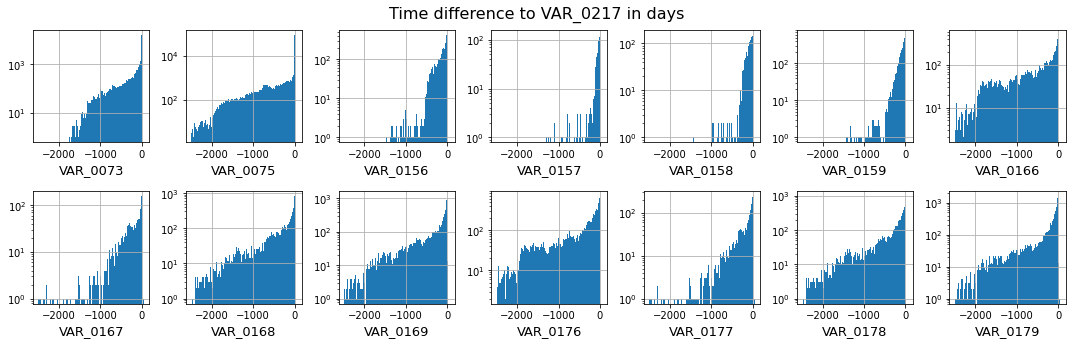

In [46]:
cols_t = sorted(set(dft_diff.columns) - set(['VAR_0204','VAR_0217']))

fig, ax = plt.subplots(2,7,figsize=(15,5))

ax = ax.ravel()

fig.suptitle('Time difference to VAR_0217 in days',fontsize=16)

for i, col in enumerate(cols_t):
    
    t_unit = np.timedelta64(1,'D')
    
    ax[i].hist((dft[col]-dft['VAR_0217'])/t_unit, range=(-2500,50),bins=255)

    ax[i].grid()
    ax[i].set_yscale('log')
    ax[i].set_xlabel(col,fontsize=13)

fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

Interestingly, all the distributions are falling steeply from 0 to earlier days. This means that VAR_217 might describe an upper limit of the dates recorded in other columns.

There's also column VAR_075 that is fully filled with data, just like columns VAR_205 and VAR_217. Let's plot the time difference between the other columns and this one too:

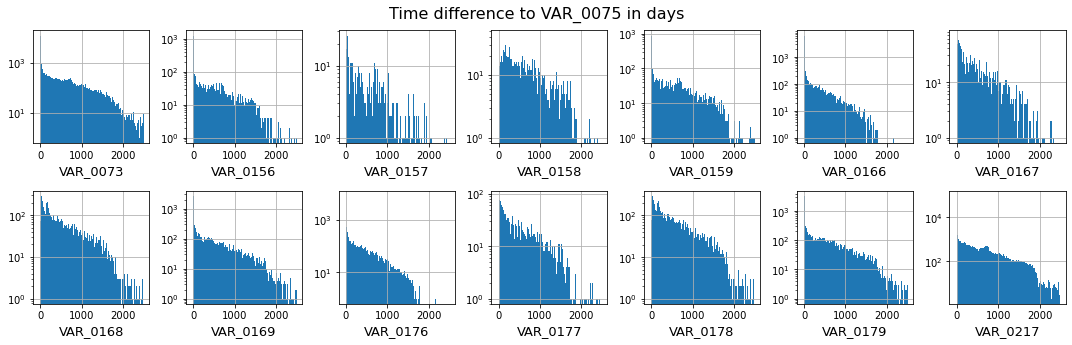

In [47]:
cols_t = sorted(set(dft_diff.columns) - set(['VAR_0204','VAR_0075']))

fig, ax = plt.subplots(2,7,figsize=(15,5))

ax = ax.ravel()

fig.suptitle('Time difference to VAR_0075 in days',fontsize=16)

for i, col in enumerate(cols_t):
    
    tunit = np.timedelta64(1,'D')
    
    ax[i].hist((dft[col]-dft['VAR_0075'])/tunit,range=(-50,2500),bins=255)

    ax[i].grid()
    ax[i].set_yscale('log')
    ax[i].set_xlabel(col,fontsize=13)

fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

The distributions are steeply falling from 0 again, this time to higher values (later dates). Combined with the previous observation, this implies that VAR_075 and VAR_217 cover the range of dates populated by other columns. In most cases, the difference between them is zero (the same date), which would explain why other columns have so many NaNs. 

In the next step, we will skip column VAR_204, convert column VAR_217 to an integer describing the number of days relative to the lowest date in that column. We will also forget column VAR_075. Finally, we will count the numbers of other non-zero datetime columns and interpret it as the number of treatments a patient surveyed in columns VAR_217 underwent. After this step, 16 datetime columns will get reduced to only two integer columns.

__To finalize:__ one more check if it's a good idea to drop all he 13 highly-empty columns:

In [48]:
#cols_t = dft.columns
cols_t = sorted(set(dft.columns) - set(['VAR_0204','VAR_0217','VAR_0075']))

for col in cols_t:
    
    print(col,':',y[dft[col].notna()].mean().round(2).values[0])

VAR_0073 : 0.38
VAR_0156 : 0.42
VAR_0157 : 0.52
VAR_0158 : 0.37
VAR_0159 : 0.42
VAR_0166 : 0.39
VAR_0167 : 0.48
VAR_0168 : 0.36
VAR_0169 : 0.39
VAR_0176 : 0.39
VAR_0177 : 0.49
VAR_0178 : 0.36
VAR_0179 : 0.39


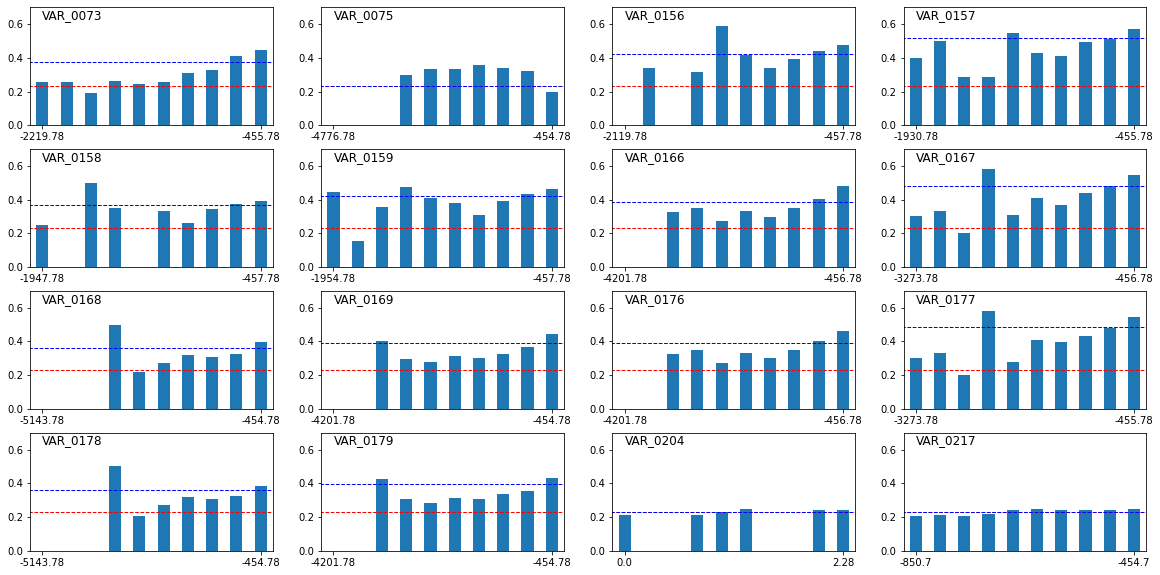

In [49]:
fig, ax = plt.subplots(4,4,figsize=(20,10))

cols_t = dft.columns

ax = ax.ravel()
#ax[13].set_axis_off()

nbins=10

for i,col in enumerate(cols_t):
    
    
    df_tmp = pd.concat((dft_diff[col]/np.timedelta64(1,'D'),y),axis=1)
    tmin = df_tmp[col].min()
    tmax = df_tmp[col].max()
#    print(col,tmin,tmax)
    
    bins = pd.cut(df_tmp[col], np.linspace(tmin,tmax,nbins+1))
    tmin = round(tmin,2)
    tmax = round(tmax,2)
    
    df_tmp.groupby(bins)['target'].mean().plot.bar(ax=ax[i],legend=None)

    ax[i].set_xticks([0,nbins-1])
    ax[i].set_xticklabels([tmin,tmax])
    ax[i].tick_params(axis='x', labelrotation=0)

    ax[i].set_xlabel('')
    ax[i].text(0.05, 0.9, col, transform=ax[i].transAxes,fontsize=12)
    
#    ax[i].set_yscale('log')

    ax[i].set_ylim(top = 0.7)   
    ax[i].hlines(y.mean(),-1,20,linewidth=1,linestyle='--',color='r');
    ax[i].hlines(y[dft[col].notna()].mean(),-1,20,linewidth=1,linestyle='--',color='b');

### 5. Summary<a id='5'></a>

In the course of this notebook we created a new dataframe with the timedelta type, let's write it out and start the next section from it. All changes discussed for other types will be applied in the next notebook on feature engineering.

In [51]:
dft_diff.to_csv('data/work_datetimes_diff.csv')
dpt_diff.to_csv('data/pred_datetimes_diff.csv')

! date
! ls -lrth data/ | grep csv | grep diff

Thu Jan 28 19:40:10 EST 2021
-rw-r--r-- 1 robertc robertc  19M Jan 28 19:40 work_datetimes_diff.csv
-rw-r--r-- 1 robertc robertc  19M Jan 28 19:40 pred_datetimes_diff.csv
